<a href="https://colab.research.google.com/github/AdrienBertaud/Image-Classification-/blob/main/miniproject2_Adrien.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Miniproject: Image Classification

### Description

One of the oldest traditions in deep learning is to first tackle the fun problem of MNIST classification. [The MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://keras.io/examples/) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "Adam", "convolutional neural network", "training and validation data", "overfitting", "regularization", and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data (i.e. training).
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [57]:
student1 = "Firstname Lastname"
student2 = ""

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [58]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD, Adam
from keras import regularizers

### Plotting

In [59]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "train")
    ax1.plot(history.history['val_loss'], label = "val")
    ax2.plot(history.history['accuracy'], label = "train")
    ax2.plot(history.history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 1: Data import and visualization (6 points)

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. 
The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the training converges faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long. 

1. As a warm-up exercise, use the importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the function `plot_some_samples` defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (2 pts)
3. To prepare for training: 1. transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (you can use `utils.to_categorical` function from keras), and 2. reshape (flatten) the input images to input vectors and rescale the input data into the range [0,1]. (2 pts)

*Hint*: Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets. 

**Answer to Question 2** (1 sentence): 

### Solution

1) Load the MNIST and Fashion-MNIST dataset.

In [60]:
import tensorflow as tf
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

2) Plot some samples of the two datasets.

MNIST


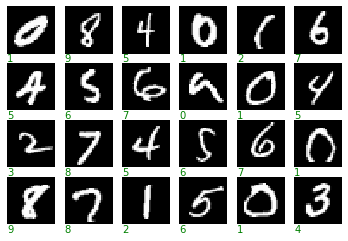

In [61]:
print("MNIST")
plot_some_samples(x_mnist_train, y_mnist_train, ncols=6, nrows=4);

Fashion-MNIST


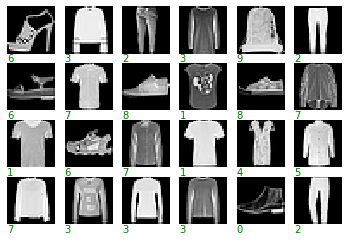

In [62]:
print("Fashion-MNIST")
plot_some_samples(x_train, y_train, ncols=6, nrows=4);

The green digit at the bottom left of each image indicates the label of the image, i.e its classificaition. It can be interpreted as the index of the digit with value 1 (all others at 0) fot one hot coding. Without that prior labelling, no training is possible.

3) Prepare for training.

In [63]:
# transform the labels to one hot coding
from keras.utils import to_categorical
y_mnist_train_one_hot = to_categorical(y_mnist_train)
y_mnist_test_one_hot = to_categorical(y_mnist_test)

for i in range(5):
    print("{0} => {1}".format(y_mnist_train[i], y_mnist_train_one_hot[i]))

5 => [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 => [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [64]:
# reshape (flatten) the input images to input vectors
print("MNIST")
original_mnist_train_shape = x_mnist_train.shape
original_mnist_test_shape = x_mnist_test.shape
x_mnist_train = x_mnist_train.reshape(x_mnist_train.shape[0], x_mnist_train.shape[1]*x_mnist_train.shape[2])
x_mnist_test = x_mnist_test.reshape(x_mnist_test.shape[0], x_mnist_test.shape[1]*x_mnist_test.shape[2])
print("Reshaped training data from {0} to {1}".format(original_mnist_train_shape, x_mnist_train.shape))
print("Reshaped test data from {0} to {1}".format(original_mnist_test_shape, x_mnist_test.shape))

MNIST
Reshaped training data from (60000, 28, 28) to (60000, 784)
Reshaped test data from (10000, 28, 28) to (10000, 784)


In [65]:
print("Fashion-MNIST")
original_train_shape = x_train.shape
original_test_shape = x_test.shape
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
print("Reshaped training data from {0} to {1}".format(original_train_shape, x_mnist_fashion_train_reshaped.shape))
print("Reshaped test data from {0} to {1}".format(original_test_shape, x_mnist_fashion_test_reshaped.shape))

Fashion-MNIST
Reshaped training data from (60000, 28, 28) to (60000, 784)
Reshaped test data from (10000, 28, 28) to (10000, 784)


In [66]:
# rescale the input data into the range [0,1]
max_grey_value = 255.0

print("MNIST")
print("Max value in initial dataset:", np.max(x_mnist_train), np.max(x_mnist_test))
print("Min value in initial dataset:", np.min(x_mnist_train), np.min(x_mnist_test))
x_mnist_train = x_mnist_train / max_grey_value  
x_mnist_test = x_mnist_test / max_grey_value 
print("Max value in rescaled dataset:", np.max(x_mnist_train), np.max(x_mnist_test))
print("Min value in rescaled dataset:", np.min(x_mnist_train), np.min(x_mnist_test))

MNIST
Max value in initial dataset: 255 255
Min value in initial dataset: 0 0
Max value in rescaled dataset: 1.0 1.0
Min value in rescaled dataset: 0.0 0.0


In [67]:
print("Fashion-MNIST")
print("Max value in initial dataset (train/test):", np.max(x_train), np.max(x_test))
print("Min value in initial dataset (train/test):", np.min(x_train), np.min(x_test))
x_train = x_train / max_grey_value  
x_test = x_test / max_grey_value 
print("Max value in rescaled dataset (train/test):", np.max(x_train), np.max(x_test))
print("Min value in rescaled dataset (train/test):", np.min(x_train), np.min(x_test))

Fashion-MNIST
Max value in initial dataset: 255 255
Min value in initial dataset: 0 0
Max value in rescaled dataset: 1.0 1.0
Min value in rescaled dataset: 0.0 0.0


## Exercise 2: No hidden layer (10 points)

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). Note that in this miniproject there is no real test dataset and what is loaded as a test dataset is used for validation. First, implement 1.-3. for the MNIST dataset.  

1. Implement the model with the following specifications: use the softmax activation for the output layer, use the categorical_crossentropy loss, choose stochastic gradient descent for the optimizer, and add the accuracy metric to the metrics. (5 pts)
2. Train for as many epochs as needed to see no further decrease in the validation loss. (1 pt)
3. Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above. (1 pt)
4. Repeat the above steps for fitting the network to the Fashion-MNIST dataset. (2 pts)
5. Report the best validation accuracy achieved for each one of the datasets. Do you observe overfitting already for this simple model? Answer separetely for the MNIST dataset and Fashion-MNIST dataset. (1 pt) 

*Hint:* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).

**Answer to Question 5** (max 2 sentences): 

### Solution

## Exercise 3: One hidden layer, different optimizers (10 points)

Train a network with one hidden layer and compare different optimizers for the MNIST dataset.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way. (1 pt)
2. Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate $\eta$ is very large (for ex. $\eta=1$), and very small (for ex. $\eta=0.001$)? Comment on the fluctuations of the learning curve. (2 pts)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate). (1pt)
4. Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (1 pts)
5. Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so? (2 pts)
6. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples`. (1 pt)

Real-world datasets are labeled by some people and sometimes there are mistakes in the labeling. We will corrupt labels of the MNIST dataset artifically, and observe an overfitting to this noisy dataset with Adam. 

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)

**Answer to Question 2** (max 2 sentences): 

**Answer to Question 5** (max 3 sentences): 

**Answer to Question 7** (max 2 sentences): 

### Solution

In [9]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' train')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' val')
    ax1.plot(history_adam.history['loss'], label=label2 + ' train')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' val')
    ax2.plot(history_sgd.history['accuracy'], label=label1 + ' train')
    ax2.plot(history_sgd.history['val_accuracy'], label=label1 + ' val')
    ax2.plot(history_adam.history['accuracy'], label=label2 + ' train')
    ax2.plot(history_adam.history['val_accuracy'], label=label2 + ' val')
    finalize_standardplot(fig, ax1, ax2)
    return fig

## Exercise 4: Model performance as a function of number of hidden neurons (8 + 2 points)

Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network in Exercise 3, we use the Fashion-MNIST dataset from now on to compare the performances of more complex models. In this exercise, we investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)
2. Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)
3. Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
4. BONUS: Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
5. Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

**Answer to Question 2** (max 2 sentences): 

**Answer to Question 5** (max 3 sentences): 

### Solution

## Exercise 5: Going deeper: tricks and regularization (10 + 2 points)

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. We use Fashion-MNIST dataset in this exercise.  

1. Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs. (2 pts)
2. Plot the learning curves and report the best validation accuracy. Do you observe overfitting? (2 pts)
3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?  (2 pts)
4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)
5. BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

6. Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure. (2 pts)

**Answer to Question 2** (max 1 sentence):   

**Answer to Question 3** (max 2 sentences): 

**Answer to Question 4** (max 2 sentences): 

**Answer to Question 5 (BONUS)** (max 2 sentences): 

**Answer to Question 6** (max 2 sentences): 

### Solution

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

Convolutional neural networks have an inductive bias that is well adapted to image classification. 

1. Design a convolutional neural network and train it without using explicit regularizers. (2 pts)
2. Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases. (4 pts)
3. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot. (2pts)
4. How does the CNN performance compare to the so far best performing (deep) neural network model? (2 pts)

*Hint:* You may get valuable inspiration from the keras [examples](https://keras.io/examples/), [for example](https://keras.io/examples/vision/mnist_convnet/).

**Answer to Question 4**: 

### Solution